In [1]:
# Importing important libraries and modules
import cv2
import os
import glob
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dropout, Conv2D, Dense, BatchNormalization, AveragePooling2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# We have to read the data from a file which contains data in the form of image. 
# The folder is named as 'train' and it contains images of different breed of dogs and for label corresponding to each image we will need to read labels.csv

# First of all we will extract the detail of all the data and save all of them in terms of dataframe with foldername, imagename, objectname and labels
detail = sorted(glob.glob("../input/dog-breed-identification/train/*"))
foldername = [str(i.split("in/")[0]) + "in" for i in detail]
imagename = [str(i.split("/")[4]) for i in detail]
label = np.array((pd.read_csv('../input/dog-breed-identification/labels.csv'))["breed"])

# Defining dataframe and saving all the extracted information in that dataframe
data_detail = pd.DataFrame() 
data_detail["foldername"] = foldername
data_detail["imagename"] = imagename
data_detail["label"] = label


# Analying the train data detail
print("\nNumber of images in training set = "+str(len(detail)))
print(data_detail.columns)
data_detail.head()


Number of images in training set = 10222
Index(['foldername', 'imagename', 'label'], dtype='object')


,foldername,imagename,label
0,../input/dog-breed-identification/train,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,../input/dog-breed-identification/train,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,../input/dog-breed-identification/train,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,../input/dog-breed-identification/train,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,../input/dog-breed-identification/train,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


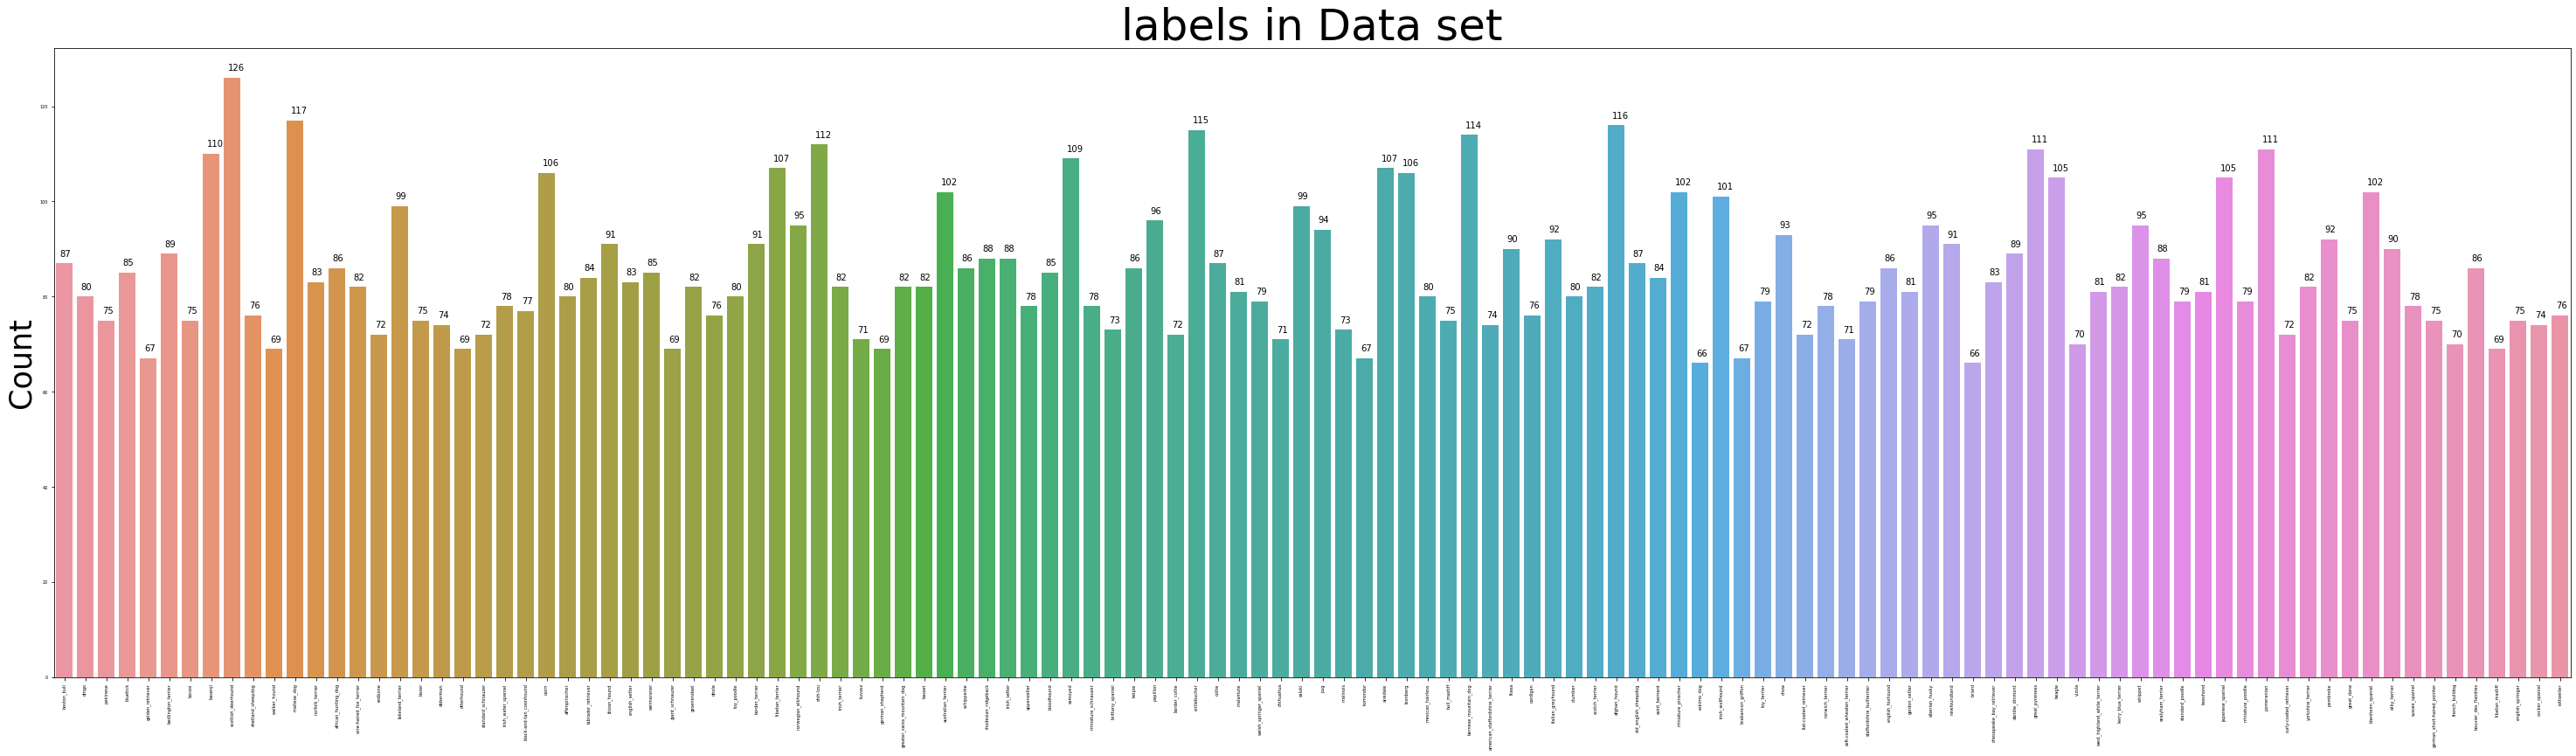

In [3]:
# Checking the no of images we have for each class
fig = plt.figure(figsize = (40, 10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("labels in Data set", fontsize = 50)
sns.countplot(x = "label", data = data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 10, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 35)
plt.tick_params(labelsize = 5)
plt.xticks(rotation = 90)
plt.show()               # Clearly it shows that there is a case of class imbalance here

In [4]:
# Splitting training set into initial training set and test set
train_data_detail, test_data_detail = train_test_split(data_detail, stratify=data_detail["label"], test_size = 0.08)

# Splitting training data into final training set and cross validation set
train_data_detail, cv_data_detail = train_test_split(train_data_detail, stratify=train_data_detail["label"], test_size = 0.086956)
train_data_detail.shape, test_data_detail.shape, cv_data_detail.shape

((8586, 3), (818, 3), (818, 3))

In [5]:
# Resetting index of train, cross validation and test set
train_data_detail.reset_index(inplace = True, drop = True)
cv_data_detail.reset_index(inplace = True, drop = True)
test_data_detail.reset_index(inplace = True, drop = True)

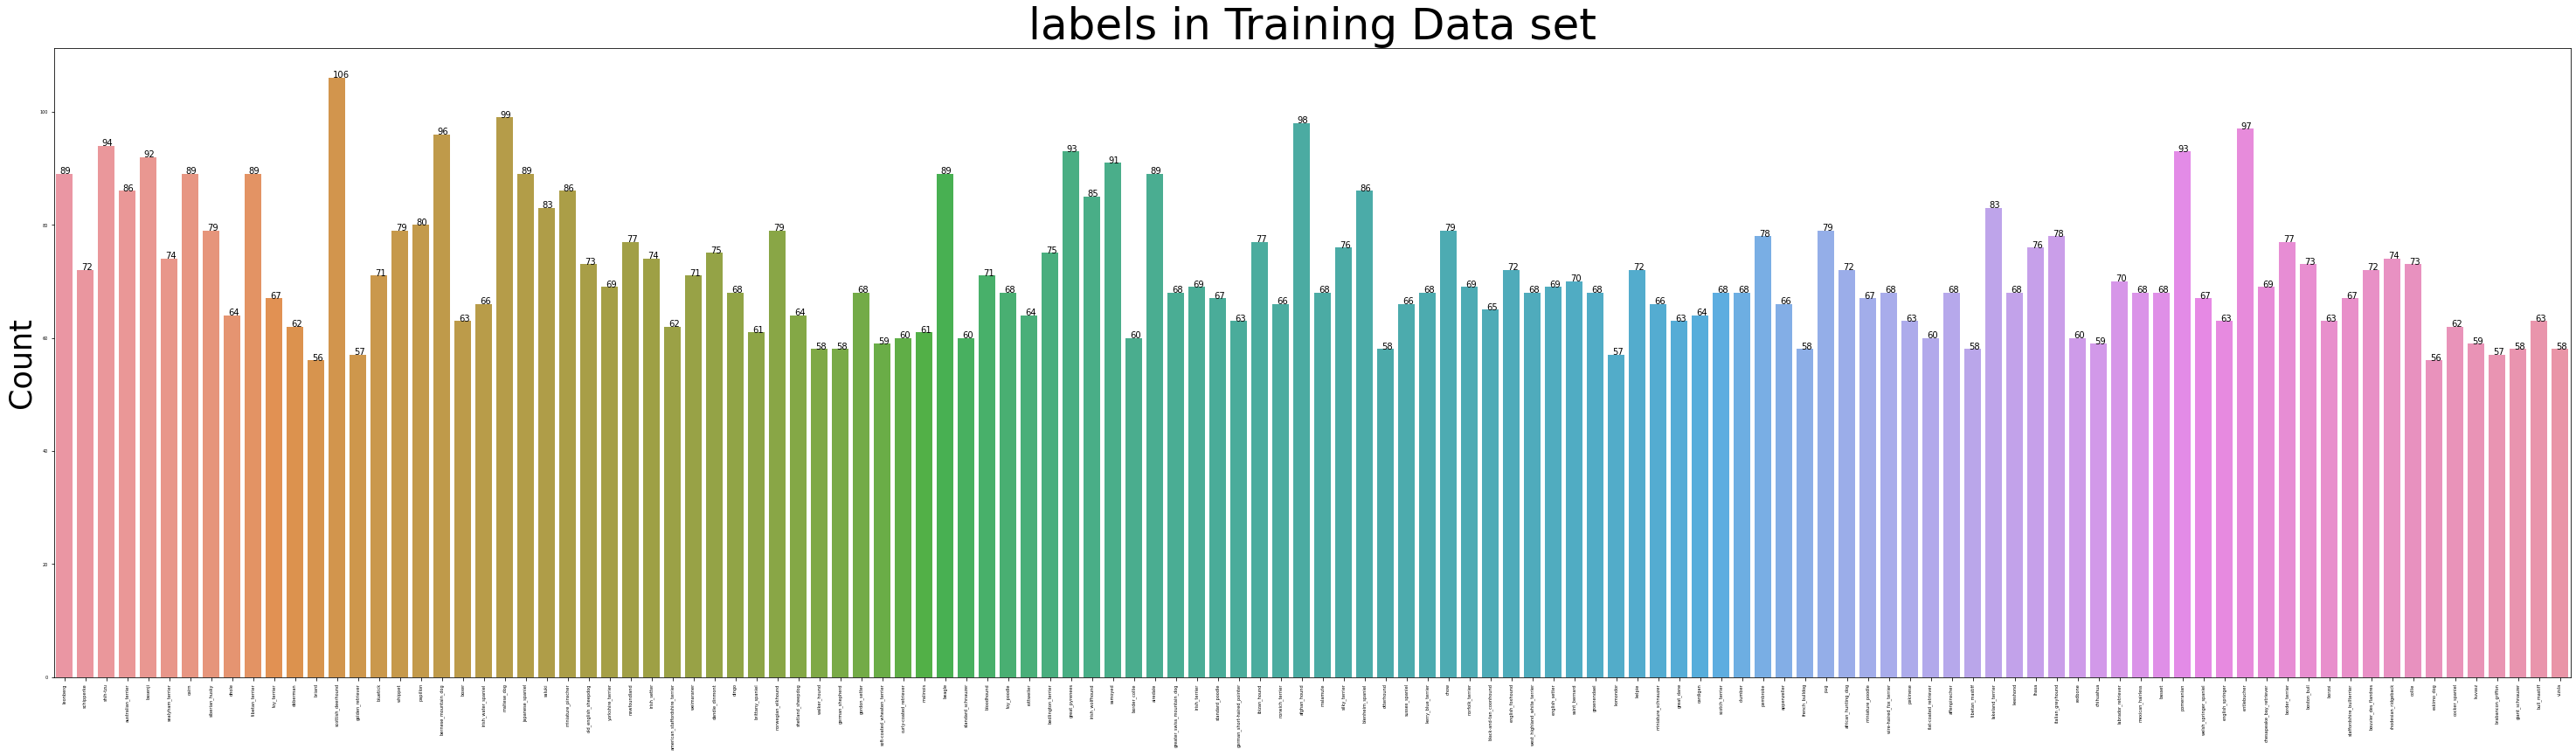

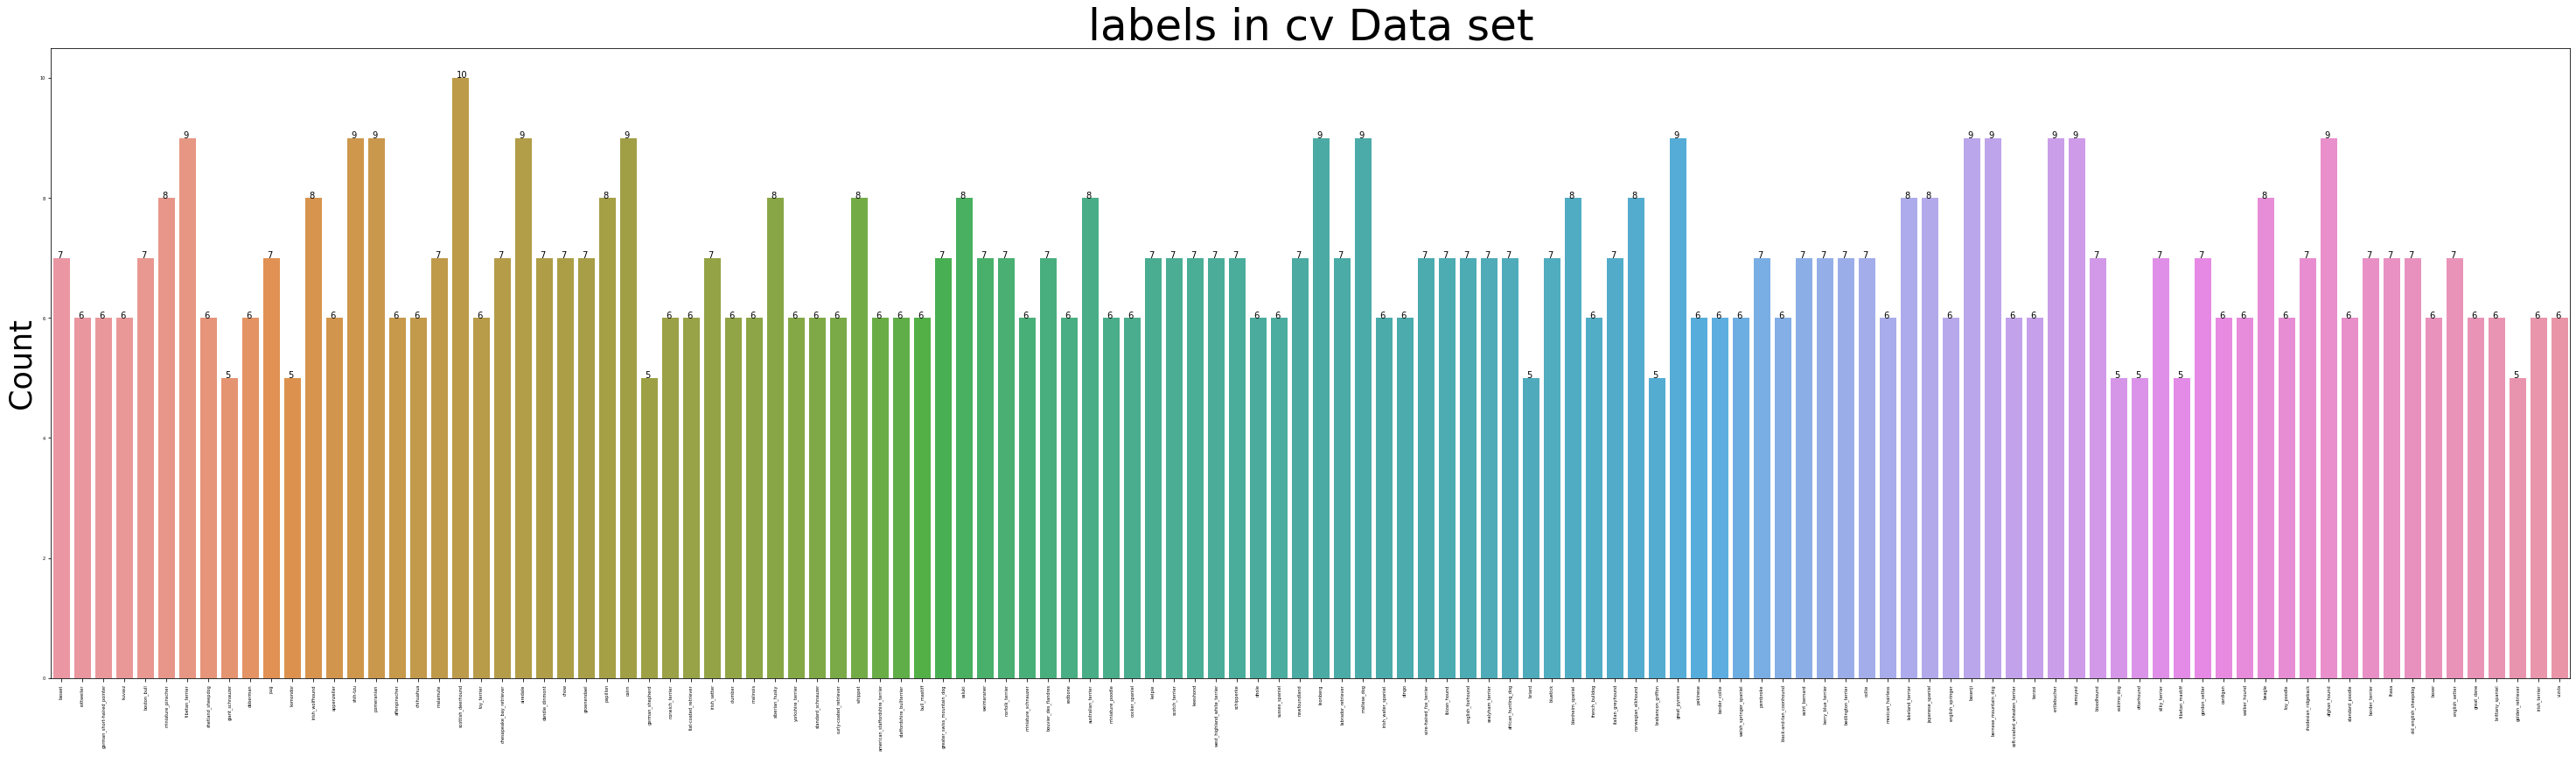

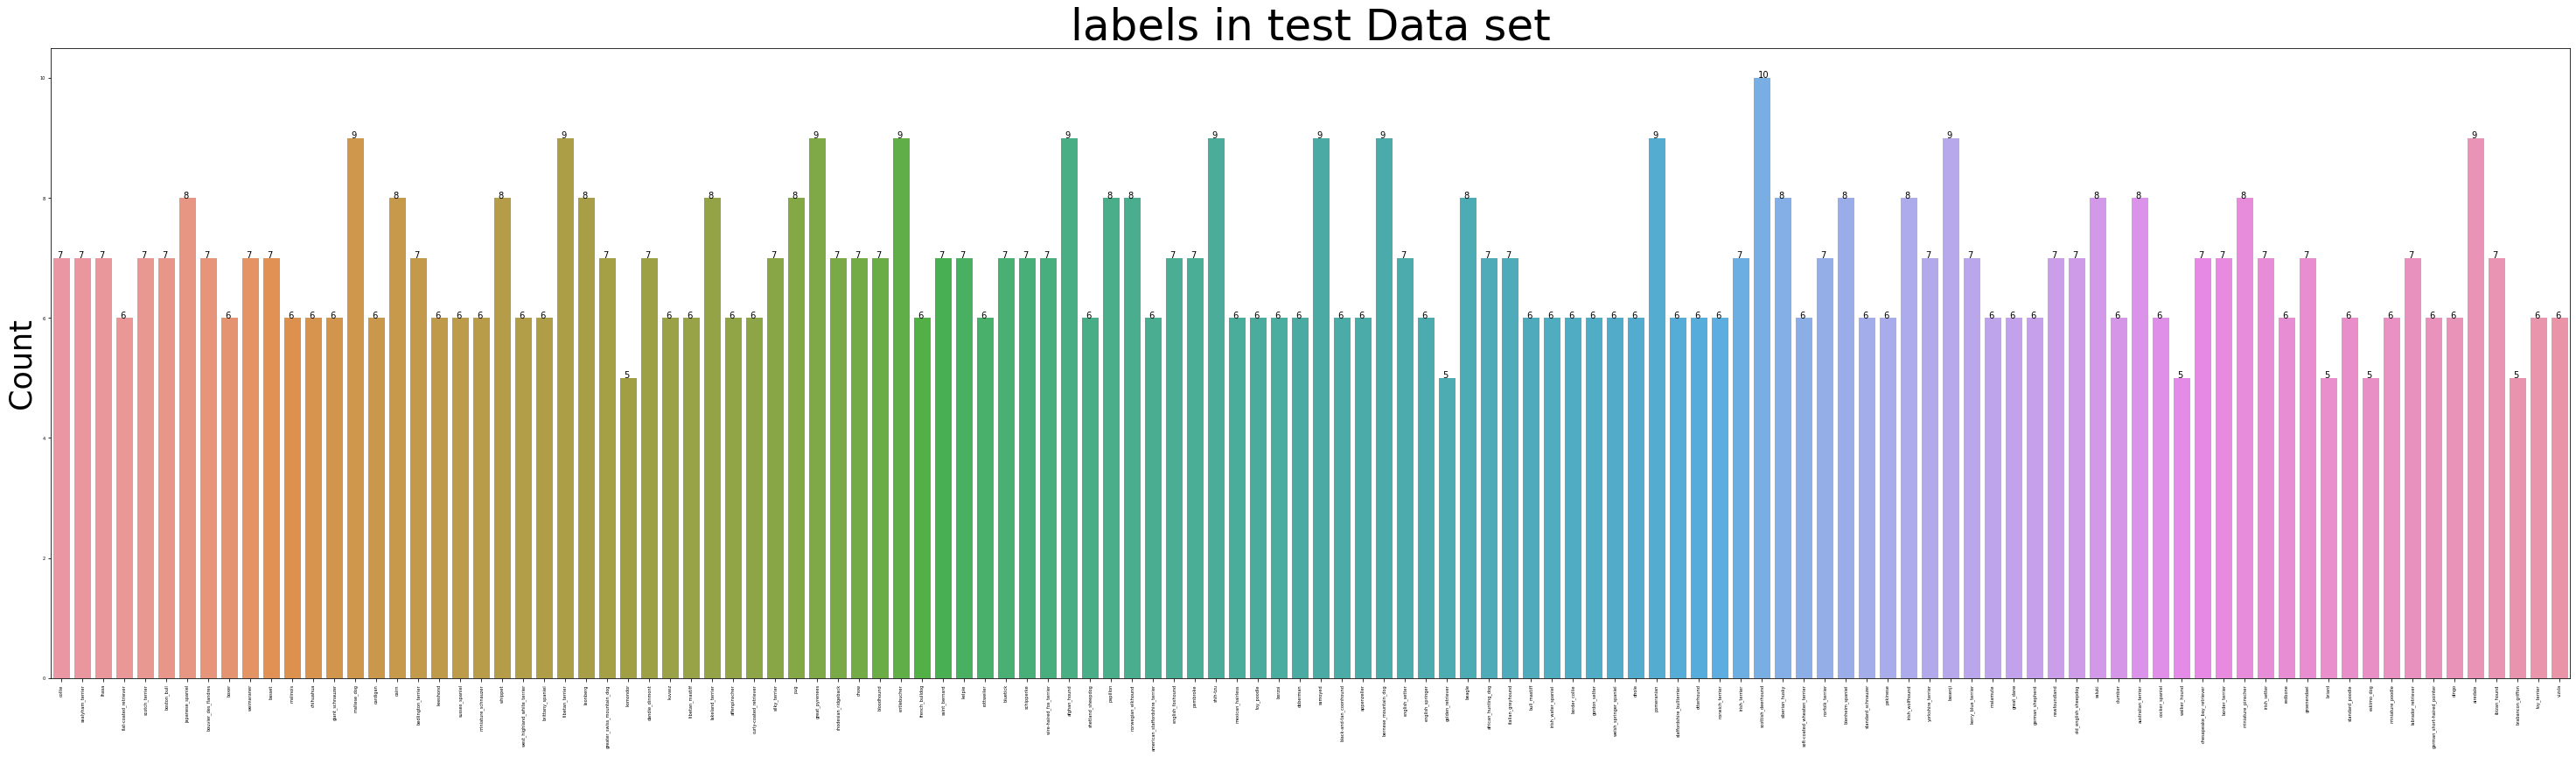

In [6]:
# plotting  and printing distribution of each class in all train, cross validation and test set

# for training data.................................................................................................................
fig = plt.figure(figsize = (40, 10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("labels in Training Data set", fontsize = 50)
sns.countplot(x = "label", data = train_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height(), s = str(i.get_height()), fontsize = 10, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 35)
plt.tick_params(labelsize = 5)
plt.xticks(rotation = 90)
plt.show()

# for cross validation data............................................................................................................
fig = plt.figure(figsize = (40, 10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("labels in cv Data set", fontsize = 50)
sns.countplot(x = "label", data = cv_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height(), s = str(i.get_height()), fontsize = 10, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 35)
plt.tick_params(labelsize = 5)
plt.xticks(rotation = 90)
plt.show()

# for test data............................................................................................................................
fig = plt.figure(figsize = (40, 10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("labels in test Data set", fontsize = 50)
sns.countplot(x = "label", data = test_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height(), s = str(i.get_height()), fontsize = 10, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 35)
plt.tick_params(labelsize = 5)
plt.xticks(rotation = 90)
plt.show()


In [7]:
# To do tranfer learning creating a base model from VGG-16 pre trained model on Imagenet datset
base_model = Xception(weights='imagenet', include_top=False)

In [8]:
# Changing the data into an array of pixels and labels so that it can be fed into the model expect test which is for prediction only
# Initially it was in the form of a DataFrame
# Also Creating bottleneck features from base model and storing them

In [9]:
# for training data
train_x = []
train_y = []
for i in range(len(train_data_detail)):
        path1 = train_data_detail["foldername"][i]
        path2 = train_data_detail["imagename"][i]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.resize(image, (224,224))
        #here, we are normalizing the images
        image = image/255.0 
        image = image.reshape(1,224,224,3)
        image = base_model.predict(image)
        image = image.reshape(image.shape[1],image.shape[2],image.shape[3] )
        #Creating and saving each image in the form of numerical data in an array 
        train_x.append(image)
        #appending corresponding labels 
        train_y.append(train_data_detail['label'][i])  
        if i%500 == 0:
            print("no of images processed =",i)
train_x = np.array(train_x,dtype=np.uint8)
train_y = np.array(pd.get_dummies(train_y),dtype=np.uint8)
print(" for training data ", train_x.shape, train_y.shape)

no of images processed = 0
no of images processed = 500
no of images processed = 1000
no of images processed = 1500
no of images processed = 2000
no of images processed = 2500
no of images processed = 3000
no of images processed = 3500
no of images processed = 4000
no of images processed = 4500
no of images processed = 5000
no of images processed = 5500
no of images processed = 6000
no of images processed = 6500
no of images processed = 7000
no of images processed = 7500
no of images processed = 8000
no of images processed = 8500
 for training data  (8586, 7, 7, 2048) (8586, 120)


In [10]:
# for test data
cv_x = []
cv_y = []
for i in range(len(cv_data_detail)):
        path1 = cv_data_detail["foldername"][i]
        path2 = cv_data_detail["imagename"][i]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.resize(image, (224,224))
        #here, we are normalizing the images
        image = image/255.0 
        image = image.reshape(1,224,224,3)
        image = base_model.predict(image)
        image = image.reshape(image.shape[1],image.shape[2],image.shape[3] ) 
        #Creating and saving each image in the form of numerical data in an array 
        cv_x.append(image)
        #appending corresponding labels 
        cv_y.append(cv_data_detail['label'][i]) 
        if i%500 == 0:
            print("no of images processed =",i)
cv_x = np.array(cv_x,dtype=np.uint8)
cv_y = np.array(pd.get_dummies(cv_y),dtype=np.uint8)
print(" for cv data ",cv_x.shape, cv_y.shape)

no of images processed = 0
no of images processed = 500
 for cv data  (818, 7, 7, 2048) (818, 120)


In [11]:
# Defining a model 
def model():
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_x.shape[1:]))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='softmax'))
    
    return model
model = model()
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compiling and running the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])
hist = model.fit(train_x, train_y, validation_data=(cv_x, cv_y), epochs = 25)

Epoch 1/25
269/269 [==============================] - 2s 6ms/step - loss: 2.9486 - accuracy: 0.3830 - val_loss: 1.2152 - val_accuracy: 0.6760
Epoch 2/25
269/269 [==============================] - 1s 4ms/step - loss: 0.9911 - accuracy: 0.7359 - val_loss: 1.1062 - val_accuracy: 0.6980
Epoch 3/25
269/269 [==============================] - 1s 4ms/step - loss: 0.7270 - accuracy: 0.8062 - val_loss: 1.0669 - val_accuracy: 0.6993
Epoch 4/25
269/269 [==============================] - 1s 4ms/step - loss: 0.5843 - accuracy: 0.8488 - val_loss: 1.0855 - val_accuracy: 0.6846
Epoch 5/25
269/269 [==============================] - 1s 4ms/step - loss: 0.4877 - accuracy: 0.8760 - val_loss: 1.0855 - val_accuracy: 0.6895
Epoch 6/25
269/269 [==============================] - 1s 4ms/step - loss: 0.4092 - accuracy: 0.8984 - val_loss: 1.0979 - val_accuracy: 0.6883
Epoch 7/25
269/269 [==============================] - 1s 4ms/step - loss: 0.3533 - accuracy: 0.9158 - val_loss: 1.1136 - val_accuracy: 0.6858
Epoch 

In [13]:
# deleting some data to free up ram
del train_x
del train_y
del cv_x
del cv_y
gc.collect()

1717

In [14]:
# visualizing losses and accuracy with epochs 
epoch_number = []
for epoch in range(25):
    epoch_number.append(epoch + 1)
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']

In [15]:
# printing a table depicting the detail about the trained model
log_frame = pd.DataFrame(columns = ["Epoch", "Train_Loss", "Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Train_Loss"] = train_loss
log_frame["Train_Accuracy"] = train_acc
log_frame["CV_Loss"] = val_loss
log_frame["CV_Accuracy"] = val_acc 
log_frame

,Epoch,Train_Loss,Train_Accuracy,CV_Loss,CV_Accuracy
0,1,2.026353,0.540997,1.215158,0.676039
1,2,0.936723,0.744235,1.106237,0.698044
2,3,0.734137,0.797461,1.066853,0.699266
3,4,0.596386,0.837759,1.085501,0.684597
4,5,0.499830,0.866410,1.085521,0.689487
5,6,0.419394,0.892965,1.097920,0.688264
6,7,0.362209,0.909154,1.113609,0.685819
7,8,0.313670,0.924878,1.115964,0.694377
8,9,0.271621,0.939902,1.135047,0.683374
9,10,0.239325,0.948754,1.142242,0.694377


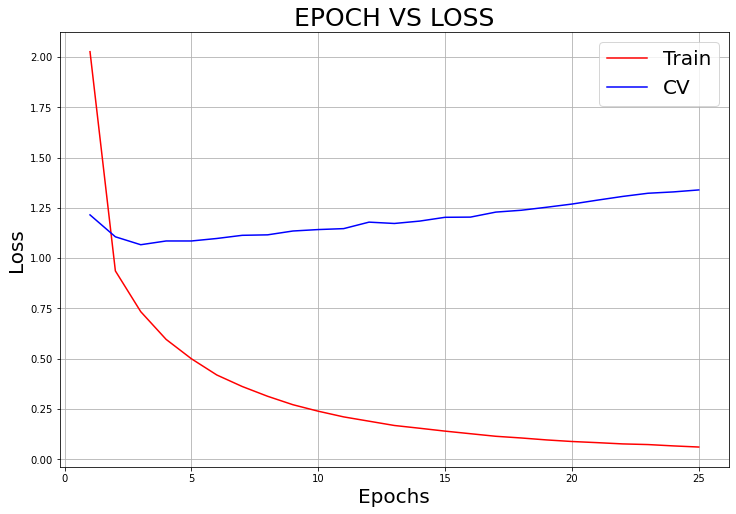

In [16]:
# plotting epoch vs loss
def plotting(epoch, train_loss, CV_loss, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_loss, color = 'red', label = "Train")
    axes.plot(epoch, CV_loss, color = 'blue', label = "CV")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Loss", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log_frame["Epoch"]), list(log_frame["Train_Loss"]), list(log_frame["CV_Loss"]), "EPOCH VS LOSS") 

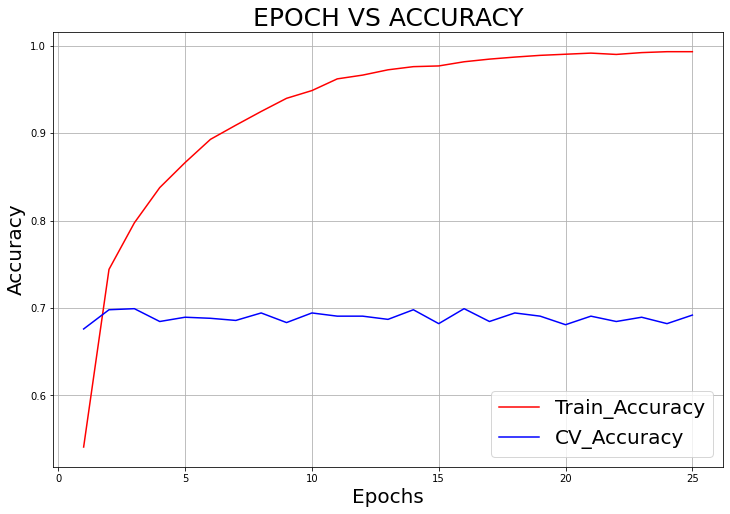

In [17]:
# plotting epoch vs accuracy
def plotting(epoch, train_acc, CV_acc, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_acc, color = 'red', label = "Train_Accuracy")
    axes.plot(epoch, CV_acc, color = 'blue', label = "CV_Accuracy")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Accuracy", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log_frame["Epoch"]), list(log_frame["Train_Accuracy"]), list(log_frame["CV_Accuracy"]), "EPOCH VS ACCURACY") 

In [18]:
# for cv data
test_x = []
test_y = []
for i in range(len(test_data_detail)):
        path1 = test_data_detail["foldername"][i]
        path2 = test_data_detail["imagename"][i]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.resize(image, (224,224))
        #here, we are normalizing the images
        image = image/255.0 
        image = image.reshape(1,224,224,3)
        image = base_model.predict(image)
        image = image.reshape(image.shape[1],image.shape[2],image.shape[3] ) 
        #Creating and saving each image in the form of numerical data in an array 
        test_x.append(image)
        #appending corresponding labels 
        test_y.append(test_data_detail['label'][i])  
test_x = np.array(test_x,dtype=np.uint8)
test_y = np.array(pd.get_dummies(test_y),dtype=np.uint8)
print(" for test data ",test_x.shape, test_y.shape)

 for test data  (818, 7, 7, 2048) (818, 120)


In [19]:
# predicting on test data
test_predict = model.predict(test_x)

In [20]:
# log loss on test data
from sklearn.metrics import log_loss
loss = log_loss(test_y, test_predict)
loss

1.2706226710348498

In [21]:
# free up ram
del test_x
del test_y
del test_predict
gc.collect()

71061

In [22]:
# We also need to read the test data for prediction from a file which contains data in the form of image. 
# The folder is named as 'test' and it contains images different breed of dogs

# First of all we will extract the detail of all the data and save all of them in terms of dataframe with foldername and imagename only
detail = sorted(glob.glob("../input/dog-breed-identification/test/*"))
foldername = [str(i.split("st/")[0]) + "st" for i in detail]
imagename = [str(i.split("/")[4]) for i in detail]

# Defining dataframe and saving all the extracted information in that dataframe
test_data_for_prediction_detail = pd.DataFrame() 
test_data_for_prediction_detail["foldername"] = foldername
test_data_for_prediction_detail["imagename"] = imagename

# Analying the test data set for prediction detail
print("\nNumber of images in test data set for prediction  = "+str(len(detail)))
print(test_data_for_prediction_detail.columns)
test_data_for_prediction_detail.head()


Number of images in test data set for prediction  = 10357
Index(['foldername', 'imagename'], dtype='object')


,foldername,imagename
0,../input/dog-breed-identification/test,000621fb3cbb32d8935728e48679680e.jpg
1,../input/dog-breed-identification/test,00102ee9d8eb90812350685311fe5890.jpg
2,../input/dog-breed-identification/test,0012a730dfa437f5f3613fb75efcd4ce.jpg
3,../input/dog-breed-identification/test,001510bc8570bbeee98c8d80c8a95ec1.jpg
4,../input/dog-breed-identification/test,001a5f3114548acdefa3d4da05474c2e.jpg


In [23]:
# Changing the data into an array of pixels and labels so that it can be fed into the model for prediction 
# Initially it was in the form of a DataFrame

# for test data for prediction data
prediction = []
for i in range(len(test_data_for_prediction_detail)):
        path1 = test_data_for_prediction_detail["foldername"][i]
        path2 = test_data_for_prediction_detail["imagename"][i]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.resize(image, (224,224))
        #here, we are normalizing the images
        image = image/255.0 
        image = image.reshape(1,224,224,3)
        image = base_model.predict(image)
        image = image.reshape(image.shape[1],image.shape[2],image.shape[3] ) 
        #Creating and saving each image in the form of numerical data in an array 
        prediction.append(image) 
        if i%500 == 0:
            print("no of images processed =",i)
prediction = np.array(prediction,dtype=np.uint8)
print(" for test data for prediction ", prediction.shape)

no of images processed = 0
no of images processed = 500
no of images processed = 1000
no of images processed = 1500
no of images processed = 2000
no of images processed = 2500
no of images processed = 3000
no of images processed = 3500
no of images processed = 4000
no of images processed = 4500
no of images processed = 5000
no of images processed = 5500
no of images processed = 6000
no of images processed = 6500
no of images processed = 7000
no of images processed = 7500
no of images processed = 8000
no of images processed = 8500
no of images processed = 9000
no of images processed = 9500
no of images processed = 10000
 for test data for prediction  (10357, 7, 7, 2048)


In [24]:
# Now prediction on data to be predicted
prediction_predict = model.predict(prediction)

In [25]:
# Free up ram
del prediction
gc.collect()

28163

In [30]:
prediction_predict

array([[2.22440177e-09, 3.56564215e-07, 7.40936468e-09, ...,
        1.78931481e-09, 6.73341771e-10, 1.01183296e-07],
       [9.91074671e-07, 2.99983860e-08, 3.21750377e-08, ...,
        8.81244341e-06, 1.16970853e-06, 3.37265504e-08],
       [9.25276245e-11, 6.26847371e-02, 8.93968135e-08, ...,
        2.88621726e-04, 1.33457057e-09, 1.11959615e-08],
       ...,
       [2.33799341e-10, 2.58073590e-10, 8.99316888e-09, ...,
        1.25737381e-06, 1.59528467e-11, 5.91076201e-08],
       [4.82488247e-07, 4.90165597e-08, 1.90128233e-08, ...,
        2.38469688e-08, 4.42959248e-07, 3.11284559e-04],
       [2.25309815e-09, 2.85186088e-05, 9.89401538e-09, ...,
        3.60603226e-05, 3.68681583e-08, 5.62298563e-09]], dtype=float32)

In [31]:
# Making new dataframe with id and all the classes and then overlaping with prediction
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
classes = sorted(list(set(labels['breed'])))
submission = pd.DataFrame(columns=["id"] + list(classes))
test_path = "../input/dog-breed-identification/test"
submission["id"] = sorted([os.path.splitext(path)[0] for path in os.listdir(test_path)])
submission.loc[:,list(classes)]= prediction_predict

In [32]:
# Final submission file
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.2244e-09,3.56564e-07,7.40936e-09,8.18842e-11,1.22517e-10,7.80907e-10,2.67742e-08,4.75288e-10,7.43555e-10,...,4.50077e-07,3.88692e-09,1.73277e-09,3.16354e-11,1.35021e-10,2.78377e-09,4.51104e-10,1.78931e-09,6.73342e-10,1.01183e-07
1,00102ee9d8eb90812350685311fe5890,9.91075e-07,2.99984e-08,3.2175e-08,3.30117e-07,6.71568e-07,3.26127e-05,1.28044e-07,3.8235e-06,7.77639e-07,...,3.15464e-06,5.09624e-07,1.25635e-08,4.25831e-08,6.39423e-09,2.22228e-09,6.99647e-06,8.81244e-06,1.16971e-06,3.37266e-08
2,0012a730dfa437f5f3613fb75efcd4ce,9.25276e-11,0.0626847,8.93968e-08,4.37635e-05,9.51142e-07,1.67604e-09,4.5735e-09,5.13637e-09,2.65996e-07,...,6.61372e-11,7.00397e-08,0.00316121,1.37594e-06,0.000230941,0.00386378,2.27042e-09,0.000288622,1.33457e-09,1.1196e-08
3,001510bc8570bbeee98c8d80c8a95ec1,1.22406e-08,3.19168e-09,1.52761e-07,1.24216e-09,2.40619e-08,9.53762e-08,8.08309e-09,2.37489e-07,4.26289e-07,...,2.41103e-09,4.92192e-08,1.06955e-07,1.63936e-11,3.19726e-09,7.57298e-07,1.05622e-09,3.45388e-08,6.33829e-12,1.22362e-07
4,001a5f3114548acdefa3d4da05474c2e,4.78991e-07,7.12185e-06,1.63107e-08,6.49288e-10,4.99775e-11,1.73004e-09,1.32126e-07,3.33341e-10,2.47187e-06,...,7.33454e-08,2.76564e-09,2.45337e-09,4.26073e-10,4.52179e-12,2.30515e-08,2.55814e-06,2.53188e-07,1.6453e-06,7.09462e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,1.94514e-08,0.000425426,5.82164e-07,0.000331752,1.62761e-06,3.04273e-06,9.24393e-08,1.74464e-06,1.86987e-07,...,0.00199534,1.45197e-06,9.13635e-07,2.32927e-08,2.25655e-07,5.44364e-05,2.44403e-09,1.08002e-05,6.67957e-07,4.37798e-06
10353,fff1ec9e6e413275984966f745a313b0,1.99732e-09,8.35518e-07,8.8032e-09,7.99298e-06,1.90554e-06,4.15489e-07,2.54354e-06,1.85937e-06,5.82536e-06,...,3.04299e-08,5.53057e-10,0.00122512,2.94124e-07,0.104569,8.27397e-07,2.62332e-08,3.34286e-05,4.07583e-06,7.43915e-08
10354,fff74b59b758bbbf13a5793182a9bbe4,2.33799e-10,2.58074e-10,8.99317e-09,1.29017e-08,1.16326e-11,2.23078e-11,2.62692e-07,5.56861e-09,6.01001e-12,...,4.05287e-12,7.38715e-09,6.36187e-09,6.77544e-12,5.84882e-12,1.08179e-09,3.45002e-12,1.25737e-06,1.59528e-11,5.91076e-08
10355,fff7d50d848e8014ac1e9172dc6762a3,4.82488e-07,4.90166e-08,1.90128e-08,1.63054e-09,1.70527e-09,1.42352e-09,2.33788e-05,7.63697e-09,2.90498e-08,...,6.48714e-05,2.50477e-09,3.52885e-08,2.51714e-09,1.41276e-09,1.25631e-10,8.09562e-07,2.3847e-08,4.42959e-07,0.000311285


In [33]:
# Saving the submission file
submission.to_csv('submission.csv', index = False)